# Tuning a `multi_match` `best_fields` query

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import importlib
import os
import sys

from copy import deepcopy
from elasticsearch import Elasticsearch
from skopt.plots import plot_objective

In [4]:
# project library
sys.path.insert(0, os.path.abspath('..'))

import qopt
importlib.reload(qopt)

from qopt.notebooks import evaluate_mrr100_dev_templated, optimize_query_mrr100_templated, set_bm25_params
from qopt.optimize import Config

In [5]:
# use a local Elasticsearch or Cloud instance (https://cloud.elastic.co/)
# es = Elasticsearch('http://localhost:9200')
es = Elasticsearch('http://35.246.228.72:9200')

# set the parallelization parameter `max_concurrent_searches` for the Rank Evaluation API calls
max_concurrent_searches = 30

index = 'msmarco-document.doc2query'
template_id = 'query'
query_type = 'best_fields'

# set best BM25 params
set_bm25_params(es, index, [
    ('url', {'k1': 0.33066956222950633, 'b': 0.9589101032169087}), # 0.2201
    ('title', {'k1': 0.34885436112727763, 'b': 1.0}), # 0.2354
    ('title.bigrams', {'k1': 1.2, 'b': 0.75}), # 0.1295
    ('body', {'k1': 3.0128735487205525, 'b': 0.8200709176657588}), # 0.2645
    ('body.bigrams', {'k1': 1.9100199633100623, 'b': 0.7336619962002098}), # 0.2045
    ('expansions', {'k1': 4.870954366799399, 'b': 0.9249613913608172}), # 0.3220
    ('expansions.bigrams', {'k1': 1.2, 'b': 0.75}) # 0.2837
])

# base template for tuning
base_templates = [{
    "id": template_id,
    "template": {
        "lang": "mustache",
        "source": { "query": {} }
    }
}]

Setting BM25 params fields:
 - url: {'k1': 0.33066956222950633, 'b': 0.9589101032169087}
 - title: {'k1': 0.34885436112727763, 'b': 1.0}
 - title.bigrams: {'k1': 1.2, 'b': 0.75}
 - body: {'k1': 3.0128735487205525, 'b': 0.8200709176657588}
 - body.bigrams: {'k1': 1.9100199633100623, 'b': 0.7336619962002098}
 - expansions: {'k1': 4.870954366799399, 'b': 0.9249613913608172}
 - expansions.bigrams: {'k1': 1.2, 'b': 0.75}


## Experiments

### Base fields

Using `best_fields` over just the base fields is the best result from a previous notebook, so we will not repeat that here. It achieved MRR@100 on the dev set: **0.3079**. Note that we achieved the best score using a large number of iterations, but it's roughly the same for fewer iterations.

### Base fields + bigrams

In [5]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "tie_breaker": "{{tie_breaker}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "title.bigrams^{{title_bigrams|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
    ]
}

In [6]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'tie_breaker': 0.0,
    'url|boost': 1.0,
    'title|boost': 1.0,
    'title_bigrams|boost': 1.0,
    'body|boost': 1.0,
    'body_bigrams|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.2578
CPU times: user 1.96 s, sys: 700 ms, total: 2.66 s
Wall time: 5min 41s


In [7]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'title_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:01:13 (remains: 0:59:57)
   | 0.2720 (best: 0.2720) - {'tie_breaker': 0.5885369968906293, 'url|boost': 2.5293939821278126, 'title|boost': 9.192389745315513, 'title_bigrams|boost': 1.9319207655772135, 'body|boost': 7.202741849791908, 'body_bigrams|boost': 1.5735955543544302}
 > iteration 2/50, took 0:01:08 (remains: 0:54:45)
   | 0.2397 (best: 0.2720) - {'tie_breaker': 0.726029529102791, 'url|boost': 8.252138692164856, 'title|boost': 2.1573039582206692, 'title_bigrams|boost': 2.716515780732958, 'body|boost': 0.933790270327607, 'body_bigrams|boost': 3.1878623412180955}
 > iteration 3/50, took 0:01:17 (remains: 1:00:55)
   | 0.2523 (best: 0.2720) - {'tie_breaker': 0.6197689614180639, 'url|boost': 6.238029902715746, 'title|boost': 1.4093745650562641, 'title_bigrams|boost': 5.4610378123339185, 'body|boost':

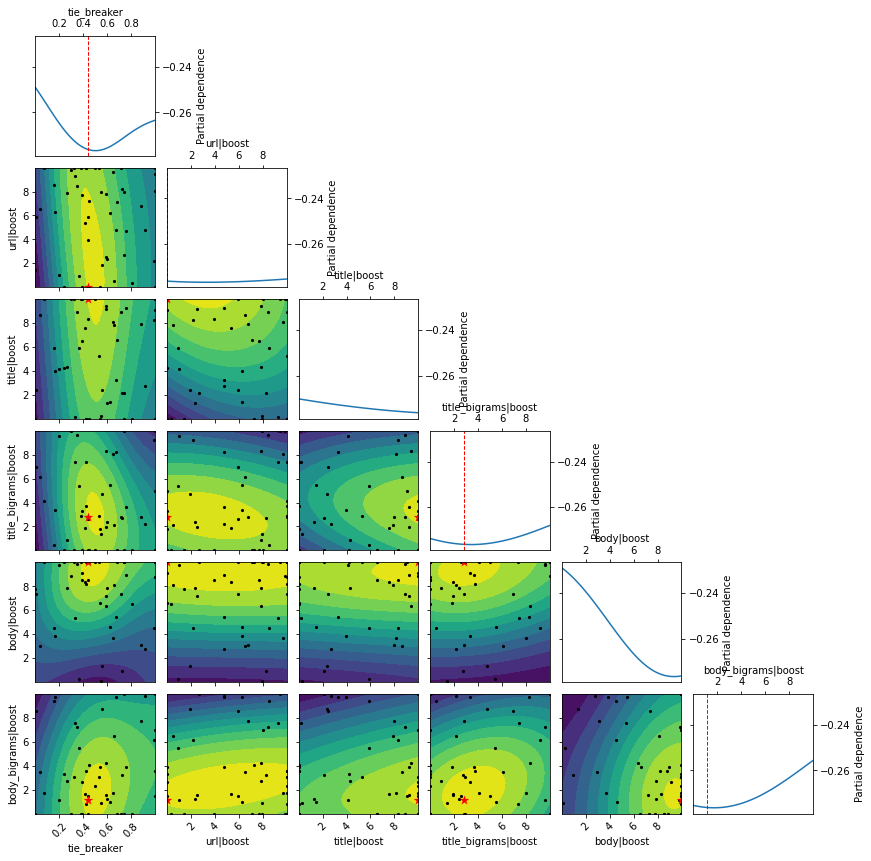

In [8]:
_ = plot_objective(metadata, sample_source='result')

In [9]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.2999
CPU times: user 2.09 s, sys: 723 ms, total: 2.81 s
Wall time: 5min 36s


In [10]:
final_params

{'tie_breaker': 0.44109124046909315,
 'url|boost': 0.0,
 'title|boost': 10.0,
 'title_bigrams|boost': 2.785470344700141,
 'body|boost': 10.0,
 'body_bigrams|boost': 1.1633009548547044}

### Base fields + expansions

In [11]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "tie_breaker": "{{tie_breaker}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "body^{{body|boost}}",
        "expansions^{{expansions|boost}}",
    ]
}

In [12]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'tie_breaker': 0.0,
    'url|boost': 1.0,
    'title|boost': 1.0,
    'body|boost': 1.0,
    'expansions|boost': 1.0,
})

Evaluation with: MRR@100
Score: 0.3229
CPU times: user 2.11 s, sys: 732 ms, total: 2.84 s
Wall time: 3min 2s


In [13]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:00:47 (remains: 0:38:54)
   | 0.3198 (best: 0.3198) - {'tie_breaker': 0.2441472870263855, 'url|boost': 5.737621997286874, 'title|boost': 3.4061282962057877, 'body|boost': 8.124644875610626, 'expansions|boost': 4.9442869913670595}
 > iteration 2/50, took 0:00:46 (remains: 0:37:31)
   | 0.3057 (best: 0.3198) - {'tie_breaker': 0.2002518769540354, 'url|boost': 1.1788615433267782, 'title|boost': 7.6185658362793625, 'body|boost': 6.2281907602722955, 'expansions|boost': 8.226097025532841}
 > iteration 3/50, took 0:00:38 (remains: 0:29:50)
   | 0.2982 (best: 0.3198) - {'tie_breaker': 0.8777228695332421, 'url|boost': 3.3744081572251123, 'title|boost': 1.8426306807148631, 'body|boost': 0.32744444900890574, 'expansions|boost': 3.1851947407017174}
 > iteration 4/50, took 0:00:45 (remains: 0:35:15)
   | 0.2750 (bes

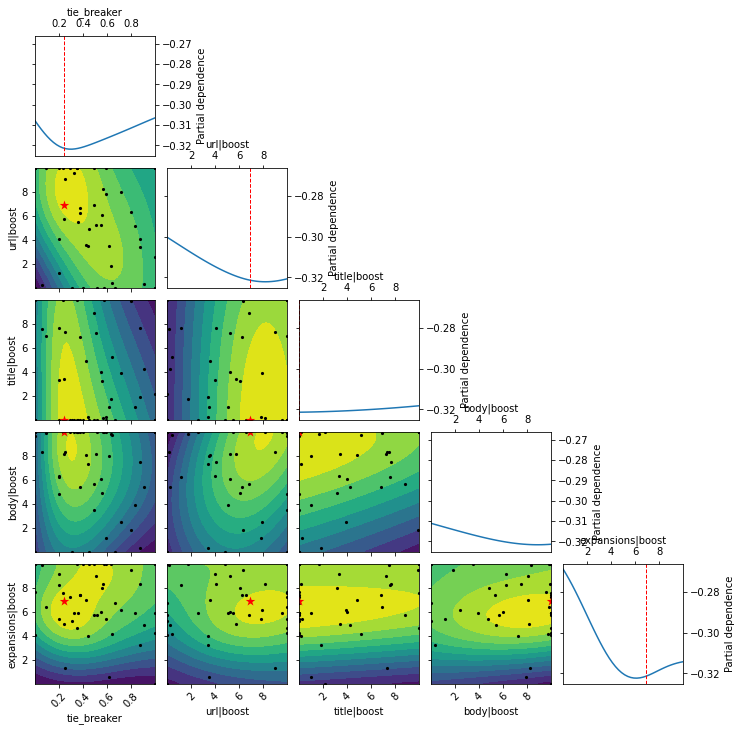

In [14]:
_ = plot_objective(metadata, sample_source='result')

In [15]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

Evaluation with: MRR@100
Score: 0.3369
CPU times: user 2.15 s, sys: 634 ms, total: 2.78 s
Wall time: 3min 24s


In [16]:
final_params

{'tie_breaker': 0.24016197941193704,
 'url|boost': 6.922824728289295,
 'title|boost': 0.0,
 'body|boost': 10.0,
 'expansions|boost': 6.912162717092728}

### Base fields + expansions + bigrams

In [9]:
_templates = deepcopy(base_templates)
_templates[0]['template']['source']['query']['multi_match'] = {
    "type": query_type,
    "query": "{{query_string}}",
    "tie_breaker": "{{tie_breaker}}",
    "fields": [
        "url^{{url|boost}}",
        "title^{{title|boost}}",
        "title.bigrams^{{title_bigrams|boost}}",
        "body^{{body|boost}}",
        "body.bigrams^{{body_bigrams|boost}}",
        "expansions^{{expansions|boost}}",
        "expansions.bigrams^{{expansions_bigrams|boost}}"
    ]
}

In [18]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params={
    'tie_breaker': 0.0,
    'url|boost': 1.0,
    'title|boost': 1.0,
    'title_bigrams|boost': 1.0,
    'body|boost': 1.0,
    'body_bigrams|boost': 1.0,
    'expansions|boost': 1.0,
    'expansions_bigrams|boost': 1.0
})

Evaluation with: MRR@100
Score: 0.3240
CPU times: user 2.18 s, sys: 695 ms, total: 2.88 s
Wall time: 7min 12s


In [ ]:
%%time

_, _, final_params, metadata = optimize_query_mrr100_templated(es, max_concurrent_searches, index, _templates, template_id,
    config_space=Config.parse({
        'method': 'bayesian',
        'num_iterations': 50,
        'num_initial_points': 20,
        'space': {
            'tie_breaker': { 'low': 0.0, 'high': 1.0 },
            'url|boost': { 'low': 0.0, 'high': 10.0 },
            'title|boost': { 'low': 0.0, 'high': 10.0 },
            'title_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'body|boost': { 'low': 0.0, 'high': 10.0 },
            'body_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions|boost': { 'low': 0.0, 'high': 10.0 },
            'expansions_bigrams|boost': { 'low': 0.0, 'high': 10.0 },
        }
    }))

Optimizing parameters
 - metric: MRR@100
 - queries: data/msmarco-document-sampled-queries.1000.tsv
 - queries: data/msmarco/document/msmarco-doctrain-qrels.tsv
 > iteration 1/50, took 0:01:23 (remains: 1:08:07)
   | 0.3005 (best: 0.3005) - {'tie_breaker': 0.9820076479816153, 'url|boost': 0.7725592893156076, 'title|boost': 3.3357297854373074, 'title_bigrams|boost': 1.8300419016710914, 'body|boost': 9.824504170213512, 'body_bigrams|boost': 8.101351319678972, 'expansions|boost': 6.894224496819051, 'expansions_bigrams|boost': 8.092348816326012}
 > iteration 2/50, took 0:01:22 (remains: 1:05:54)
   | 0.3077 (best: 0.3077) - {'tie_breaker': 0.9368647758039217, 'url|boost': 7.9224670082224, 'title|boost': 2.6508865074731363, 'title_bigrams|boost': 4.351732636698876, 'body|boost': 9.82932759939242, 'body_bigrams|boost': 2.709424960081757, 'expansions|boost': 9.68116033329841, 'expansions_bigrams|boost': 6.9099649169396}
 > iteration 3/50, took 0:01:28 (remains: 1:09:35)
   | 0.3050 (best: 0.3

In [ ]:
_ = plot_objective(metadata, sample_source='result')

In [ ]:
%%time

_ = evaluate_mrr100_dev_templated(es, max_concurrent_searches, index, _templates, template_id, params=final_params)

In [ ]:
final_params

In [23]:
# with 50/20 iterations
# this is very rare to get such a good score with this method, it's rather an outlier
# 0.3419

{
    'tie_breaker': 0.34264786943520714,
    'url|boost': 8.081607931138247,
    'title|boost': 0.24382652301551416,
    'title_bigrams|boost': 4.058979748921878,
    'body|boost': 9.971984154578822,
    'body_bigrams|boost': 3.9355330350086835,
    'expansions|boost': 9.638733168279646,
    'expansions_bigrams|boost': 2.9191170895752454
}

{'tie_breaker': 0.34264786943520714,
 'url|boost': 8.081607931138247,
 'title|boost': 0.24382652301551416,
 'title_bigrams|boost': 4.058979748921878,
 'body|boost': 9.971984154578822,
 'body_bigrams|boost': 3.9355330350086835,
 'expansions|boost': 9.638733168279646,
 'expansions_bigrams|boost': 2.9191170895752454}

## Archived experiments

Some experiments where we combined the `body` and `expansions` into a single field. This seems to need a separate `body` field as well and we don't want to create this much duplication of data, so we are ignoring the slighly better MRR in favour of simplicity and efficiency at indexing. All queries used `best_fields`.

In [24]:
# from random search
# 0.3400

{
    'tie_breaker': 0.4549730682206822,
    'url|boost': 0.34728407296025626,
    'title|boost': 8.21907753421881,
    'body|boost': 4.7837874442927735,
    'body_expansion|boost': 8.136976669448675,
    'body+expansion|boost': 8.391765667142831,
}

{'tie_breaker': 0.4549730682206822,
 'url|boost': 0.34728407296025626,
 'title|boost': 8.21907753421881,
 'body|boost': 4.7837874442927735,
 'body_expansion|boost': 8.136976669448675,
 'body+expansion|boost': 8.391765667142831}

In [25]:
# manual parameter value experimentation
# 0.3393

{
    'tie_breaker': 0.455,
    'url|boost': 0.35,
    'title|boost': 8.2,
    'body|boost': 5.0,
    'body_expansion|boost': 8.0,
    'body+expansion|boost': 20.0,
}

{'tie_breaker': 0.455,
 'url|boost': 0.35,
 'title|boost': 8.2,
 'body|boost': 5.0,
 'body_expansion|boost': 8.0,
 'body+expansion|boost': 20.0}

In [26]:
# manual parameter value experimentation
# 0.3380

{
    'tie_breaker': 0.4549730682206822,
    'url|boost': 0.34728407296025626,
    'title|boost': 8.21907753421881,
    'body|boost': 0.0,
    'body_expansion|boost': 8.136976669448675,
    'body+expansion|boost': 20.0,
}

{'tie_breaker': 0.4549730682206822,
 'url|boost': 0.34728407296025626,
 'title|boost': 8.21907753421881,
 'body|boost': 0.0,
 'body_expansion|boost': 8.136976669448675,
 'body+expansion|boost': 20.0}